<a href="https://colab.research.google.com/github/Ashupathak2001/Machine_learning/blob/main/logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
# Prepare data
# convert train & test image to tensors
dataset=MNIST(root='data/',train=True,transform=transforms.ToTensor(),download=True)
test_ds=MNIST(root='data/',train=True,transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 131208298.86it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 19124675.37it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43205148.94it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14432218.76it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# split train images to train and validate sets
data_size=len(dataset)
train_size=round(data_size*0.8)
val_size=data_size-train_size
train_ds,val_ds=random_split(dataset,[train_size,val_size])

In [ ]:
# define batch size and dataloaders
batch_size=128
train_loader=DataLoader(train_ds,batch_size,shuffle=True)
val_loader=DataLoader(val_ds,batch_size*2)
test_loader=DataLoader(test_ds,batch_size*2)

In [ ]:
# create model
class MnistModel(nn.Module):
  def __init__(self,in_features,out_classes):
    super().__init__()
    self.linear=nn.Linear(in_features,out_classes)

  def forward(self,X:torch.tensor)-> torch.tensor:
    X=X.reshape(-1,self.linear.in_features)
    Y_linear=self.linear(X)
    return Y_linear

  def predict(self,X:torch.tensor)->torch.tensor:
    Y_linear=self(X)
    probs=F.softmax(Y_linear.detach(),dim=1)
    _, Y_hat=torch.max(probs,dim=1)
    return Y_hat

  def cost_func(self,batch:list)->torch.tensor:
    images,labels=batch
    Y_linear=self(images)
    cost=F.cross_entropy(Y_linear,labels)
    return cost

  def evaluate(self,batch:list)->dict:
    images,labels=batch
    Y_hat=self.predict(images)
    acc=torch.sum(Y_hat==labels).item()/len(Y_hat)
    Y_linear=self(images)
    cost=F.cross_entropy(Y_linear.detach(),labels).item()
    res={
        'cost':cost,
        'accuracy':acc
    }
    return res

In [ ]:
in_features=28*28
out_classes=10
model=MnistModel(in_features,out_classes)

In [ ]:
# data optimizer
lr=1e-5
optimizer=torch.optim.SGD(model.parameters(),lr)

In [ ]:
# train model
def evaluateEpoch(batch_evals:list, decimals=2) -> dict:
    """Get cost & accuracy of an epoch prediction

    Args:
        batch_evals (list): list of batch evaluation
        decimals (int, optional): decimals to round values

    Returns:
        dict: containing 2 keys: cost & accuracy
    """
    batch_costs = [x['cost'] for x in batch_evals]
    batch_accs = [x['accuracy'] for x in batch_evals]
    cost = sum(batch_costs)/len(batch_costs)
    acc = sum(batch_accs)/len(batch_accs)
    res = {
        'cost': round(cost, decimals),
        'accuracy': round(acc, decimals)
    }
    return res

In [ ]:
def fit(epochs:int, model:MnistModel, optimizer:torch.optim,
        train_loader:DataLoader, val_loader:DataLoader) -> list:
    """Train model

    Args:
        epochs (int): number of iterations
        model (MnistModel): model to train
        optimizer (torch.optim): function to optimize model parameters
        train_loader (DataLoader): data loader for training phase
        val_loader (DataLoader): data loader for validation phase

    Returns:
        list: evaluation results of epochs
    """
    logs = list()
    for i in range(epochs):
        # training phase
        for batch in train_loader:
            cost = model.cost_func(batch)  # compute cost
            cost.backward()  # compute gradients
            optimizer.step()  # adjust parameters
            optimizer.zero_grad()  # reset gradients to zero

        # validation phase
        batch_evals = [model.evaluate(batch) for batch in val_loader]
        res = evaluateEpoch(batch_evals)
        logs.append(res)
        print("epoch {}: validation cost = {}, validation accuracy = {}".format(
              i+1, res['cost'], res['accuracy']))
    return logs

In [ ]:
epochs = 10
logs = fit(epochs, model, optimizer, train_loader, val_loader)

epoch 1: validation cost = 2.31, validation accuracy = 0.12
epoch 2: validation cost = 2.3, validation accuracy = 0.12
epoch 3: validation cost = 2.3, validation accuracy = 0.12
epoch 4: validation cost = 2.29, validation accuracy = 0.13
epoch 5: validation cost = 2.29, validation accuracy = 0.13
epoch 6: validation cost = 2.29, validation accuracy = 0.13
epoch 7: validation cost = 2.28, validation accuracy = 0.14
epoch 8: validation cost = 2.28, validation accuracy = 0.14
epoch 9: validation cost = 2.27, validation accuracy = 0.14
epoch 10: validation cost = 2.27, validation accuracy = 0.14


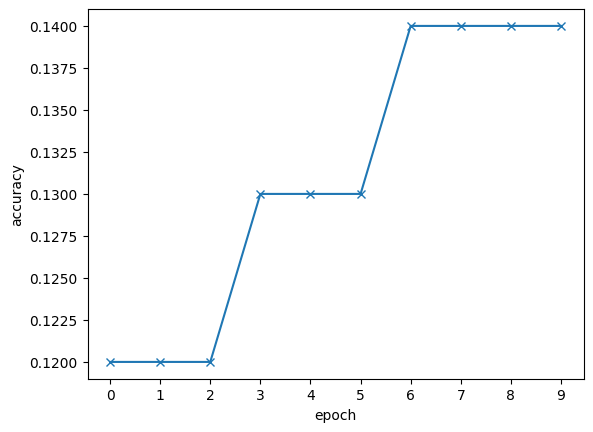

In [ ]:
# evaluations on validation set
accuracies=[log['accuracy'] for log in logs]
plt.plot(accuracies,'-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xticks(range(epochs))
plt.show();

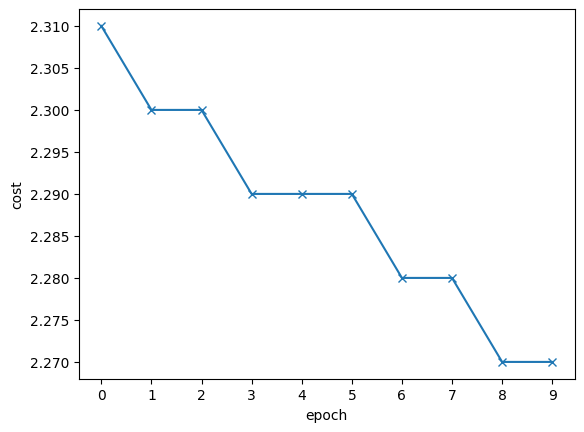

In [ ]:
costs = [log['cost'] for log in logs]
plt.plot(costs, '-x')
plt.xlabel('epoch')
plt.ylabel('cost')
plt.xticks(range(epochs))
plt.show();

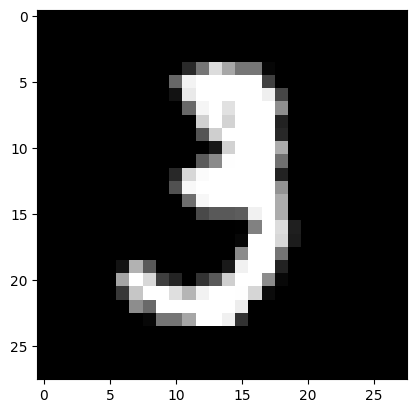

In [ ]:
# predict on test set
img, label=test_ds[10]
plt.imshow(img[0],cmap='gray');

In [ ]:
y_hat = model.predict(img)
print('Label: {}, Predicted: {}'.format(label, y_hat.item()))

Label: 3, Predicted: 3


In [ ]:
type(img), type(y_hat)

(torch.Tensor, torch.Tensor)

In [ ]:
# evaluation on test set
batch_evals=[model.evaluate(batch) for batch in test_loader]
res=evaluateEpoch(batch_evals)
print('test cost = {}, test accuracy = {}'.format(res['cost'], res['accuracy']))


test cost = 2.27, test accuracy = 0.14


In [ ]:
# saving model
filename = 'mnist-logistic.pth'
torch.save(model.state_dict(), filename)

In [ ]:
# initialize a new model
model2 = MnistModel(in_features, out_classes)
model2.state_dict()


OrderedDict([('linear.weight',
              tensor([[ 1.3880e-02,  1.4084e-02,  3.1373e-02,  ...,  6.0395e-03,
                       -8.9049e-05, -1.5715e-02],
                      [ 4.6404e-03, -3.1108e-02,  3.2672e-02,  ..., -1.7959e-02,
                       -1.5832e-02, -2.0934e-03],
                      [ 3.3073e-03, -3.5647e-02, -2.7683e-02,  ...,  1.5729e-02,
                        6.7648e-03,  2.1827e-03],
                      ...,
                      [-2.9525e-02, -2.8071e-02,  1.4871e-02,  ...,  2.5146e-02,
                        1.7142e-02,  9.5309e-03],
                      [ 2.1961e-02, -1.7935e-02, -8.0045e-03,  ..., -1.3520e-02,
                       -2.9138e-02,  3.5492e-02],
                      [-3.1078e-02,  5.4714e-03, -1.1288e-02,  ..., -8.1475e-03,
                       -2.8018e-02,  7.9268e-03]])),
             ('linear.bias',
              tensor([ 0.0347, -0.0257, -0.0215,  0.0177,  0.0342, -0.0167,  0.0059,  0.0222,
                      -0.0010,

In [ ]:
# load model from file
model2.load_state_dict(torch.load(filename))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0331, -0.0170, -0.0247,  ..., -0.0299,  0.0114,  0.0325],
                      [ 0.0166, -0.0121,  0.0356,  ...,  0.0029,  0.0224,  0.0126],
                      [ 0.0316,  0.0045, -0.0328,  ..., -0.0162,  0.0231,  0.0137],
                      ...,
                      [ 0.0241,  0.0015,  0.0052,  ..., -0.0106, -0.0239,  0.0141],
                      [ 0.0137,  0.0334,  0.0237,  ...,  0.0005, -0.0273,  0.0047],
                      [-0.0320, -0.0078, -0.0093,  ...,  0.0074, -0.0074,  0.0249]])),
             ('linear.bias',
              tensor([ 0.0327, -0.0114,  0.0342,  0.0286,  0.0008,  0.0173, -0.0232,  0.0255,
                       0.0173, -0.0347]))])